In [1]:
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt 

from scipy.stats import norm

# Combination Ratio 

 > "The efficacy of each combination relative to its respective single agents was quantified with combination ratio (CR) values, defined as the IC50 or area under the fitted dose–response curve for the combination divided by the lowest IC50 or
area under the curve (AUC) value for either single agent. By this metric, a CR value of less than 1 indicates the drug combination is more effective than either single agent. We derived these CR values because of known limitations of applying conventional synergy calculations when one or more of the single agents is completely ineffective on particular samples (25)." [1]

1. Kurtz SE, Eide CA, Kaempf A, Khanna V, Savage SL, Rofelty A, et al. Molecularly targeted drug combinations demonstrate selective effectiveness for myeloid- and lymphoid-derived hematologic malignancies. Proc Natl Acad Sci U S A. 2017 Sep 5;114(36):E7554–63. 

25. Chou TC (2006) Theoretical basis, experimental design, and computerized simulation of synergism and antagonism in drug combination studies. Pharmacol Rev 58: 621–681.

--- 

We will interpret this as the following: 

$$  CR = \frac{AUC_{combination}}{min(AUC_{drug1}, AUC_{drug2})} $$ 

# Load data 

In [6]:
data = pd.read_csv('../output/HNSCC_cleaned_data.csv')
data.head()
print( '\n'.join( data.inhibitor.unique() ) )

JQ1;BEZ235
LUCITANIB
RESVERATROL
PELITINIB
BICALUTAMIDE
METHOTREXATE
MIDOSTAURIN
TAMATINIB
BOSUTINIB
PI-103
GLYCYRRHIZIN
LUTEOLIN
GSK-690693
IBRUTINIB
DASATINIB;GEFITINIB
SORAFENIB TOSYLATE
ROSMARINIC ACID
RAPAMYCIN
VISMODEGIB
PP242
ALECTINIB
MK-2206
RUXOLITINIB PHOSPHATE;GEFITINIB
FLAVOPIRIDOL
INDIRUBIN
PF-533228
LICOCHALCONE
TANESPIMYCIN
EMODIN
BAICALIN
NVP-TAE-684
PANOBINOSTAT
PP242;GEFITINIB
FULVESTRANT
SCH-772984
MLN120B
IXABEPILONE
CANERTINIB
SELUMETINIB
I-BET 762;GEFITINIB
NF-KB
LETROZOLE
COUMARIN
AFATINIB DIMALEATE;GEFITINIB
FORETINIB
ELESCLOMOL
VEMURAFENIB
I-BET 762;BEZ235
PONATINIB HYDROCHLORIDE
SUNITINIB MALATE
CURCUMIN
PF-562271
STO609
LENVATINIB
ENTRECTINIB
ETHYL GALLATE
GDC-0941
DOVITINIB
BI-2536
TP-0903
BELINOSTAT
INK-128
TRAMETINIB;GEFITINIB
BOSUTINIB;GEFITINIB
PAZOPANIB HYDROCHLORIDE
AZD4547
POMALIDOMIDE
IDELASIB
ANWULIGNAN
STAUROSPORIN
TOZASERTIB
HESPERIDIN
ESCULETIN
SELINEXOR
INFIGRATINIB
BMX-IN-1
DASATINIB
BORTEZOMIB
NILOTINIB
ENZALUTAMIDE
CAFFEIC ACID
JQ1;GEFITINIB

# Check combinations have single-agents

In [3]:
combination_agents = data[data.inhibitor.str.contains(';')].inhibitor.unique()
single_agents = data[~data.inhibitor.str.contains(';')].inhibitor.unique()

print('number of combination agents:', combination_agents.shape[0])
print('number of single agents:', single_agents.shape[0])

missing_single_agents = set()
i = 0
for comb in combination_agents: 
    drug1, drug2 = comb.strip().split(';')
    
    if drug1 not in single_agents: missing_single_agents.add(drug1)
    elif drug2 not in single_agents: missing_single_agents.add(drug2)
    else: i+= 1
        
print('number of missing single agents:', len(missing_single_agents))
print('number of combinations with both single agents:', i)
print()
print('\n'.join(missing_single_agents))
    

number of combination agents: 108
number of single agents: 125
number of missing single agents: 5
number of combinations with both single agents: 67

CERITINIB
AFATINIB DIMALEATE
GEFITINIB
BEZ235
TRAMETINIB


# Process combination 

In [4]:
def get_combination_ratio(comb, lab_id, df, verbose=True): 
    '''
    summ 
    
    input
        comb <str> should be in form: "drug1;drug2"; There should not be more than 2 drugs in combination. 
        data <dataframe> 
        
    output 
        combination ratio <float> 
    '''
    
    data = df[df.lab_id == lab_id]
    
    assert comb.count(';') == 1, f'expected only 2 drugs, received {comb.count(";")}: \n\t {comb}'
    
    drug1, drug2 = comb.strip().split(';')
    
    if verbose: print('calculating CR for:', (drug1, drug2))
        
    comb_df = data[data.inhibitor == comb]
    drug1_df = data[data.inhibitor == drug1]
    drug2_df = data[data.inhibitor == drug2]
    
    #print(comb_df)
    #print(drug1_df)
    #print(drug2_df)
    
    assert comb_df.shape[0] == 1, f'combination data expected one entry, but got {comb_df.shape[0]}'
    assert drug1_df.shape[0] == 1, f'{drug1} data expected one entry, but got {drug1_df.shape[0]}'
    assert drug2_df.shape[0] == 1, f'{drug2} data expected one entry, but got {drug2_df.shape[0]}'
    
    comb_AUC = float( comb_df['AUC'].values[0] )
    drug1_AUC = float( drug1_df['AUC'].values[0] )
    drug2_AUC = float( drug2_df['AUC'].values[0] )
    
    CR = comb_AUC / min(drug1_AUC, drug2_AUC)
    
    return CR 

# Test example

In [8]:
print(data[data.inhibitor == 'BEZ235'])

comb = "SUNITINIB MALATE;AXITINIB"
labid = 10021

CR = get_combination_ratio(comb, labid, data)

print(f'{comb} CR value: {CR}')

Empty DataFrame
Columns: [lab_id, inhibitor, AUC, plate_loc, flagged, max_conc, call, replicates]
Index: []
calculating CR for: ('SUNITINIB MALATE', 'AXITINIB')
SUNITINIB MALATE;AXITINIB CR value: 0.9672802379145269


# Process all

In [9]:
res = {'lab_id':[], 'inhibitor':[], 'CR':[]}

npat = data.lab_id.unique().shape[0]
failed_combinations = [] 

for i, labid in enumerate( data.lab_id.unique() ): 
    print(f'in progress... {i/npat * 100 :.2f}%', end='\t\t\t\r')
    pat = data[data.lab_id == labid]
    for comb in pat[pat.inhibitor.str.contains(';')].inhibitor.unique(): 
        try: 
            CR = get_combination_ratio(comb, labid, pat, verbose=False)
            res['lab_id'].append(labid)
            res['inhibitor'].append(comb)
            res['CR'].append(CR)
        except AssertionError: 
            failed_combinations.append(comb)
            #raise
        
res = pd.DataFrame(res)
res.head()

,lab_id,inhibitor,CR
0,10004,LAPATINIB DITOSYLATE;AXITINIB,1.051159
1,10004,SUNITINIB MALATE;AXITINIB,0.998285
2,10004,LAPATINIB DITOSYLATE;BELINOSTAT,0.688008
3,10004,SUNITINIB MALATE;ROMIDEPSIN,19.225945
4,10004,LAPATINIB DITOSYLATE;GDC-0941,0.597681


# Distribution of Combination Ratio values 

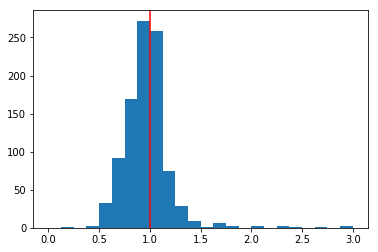

In [12]:
plt.figure()
plt.hist(res.CR, bins=np.linspace(0,3,25))
plt.axvline(1, c='r')
plt.show()

# Synergistic combinations 

We'll use less than `0.8` to denote synergy 

In [21]:
syn = res[res.CR <= 0.8]
syn.head()

,lab_id,inhibitor,CR
2,10004,LAPATINIB DITOSYLATE;BELINOSTAT,0.688008
4,10004,LAPATINIB DITOSYLATE;GDC-0941,0.597681
5,10004,SUNITINIB MALATE;BELINOSTAT,0.745983
7,10004,CANERTINIB;PI-103,0.400734
16,10004,LAPATINIB DITOSYLATE;PEMETREXED DISODIUM,0.729936


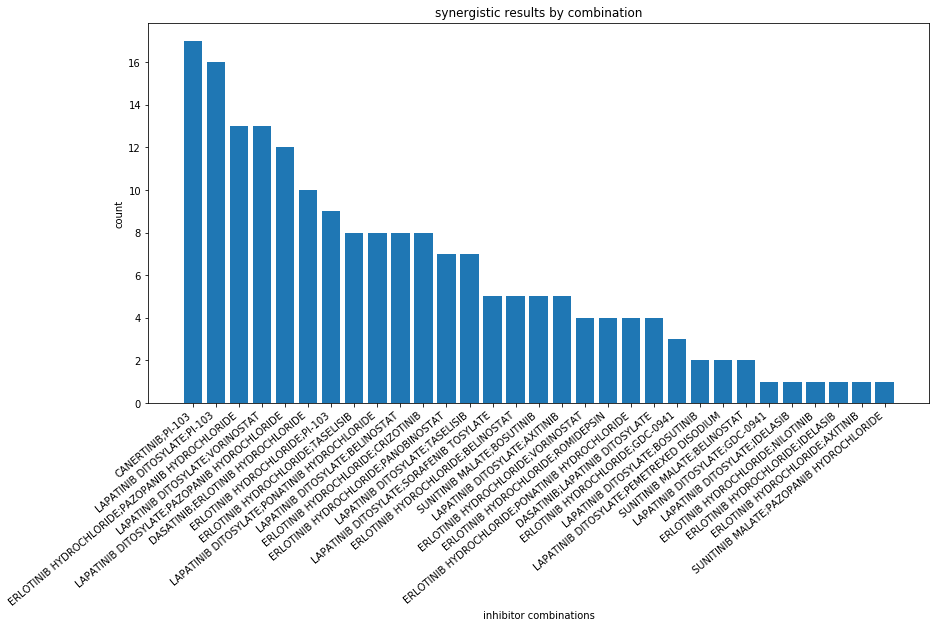

In [22]:
cnt = syn.groupby('inhibitor').count()['CR'].reset_index().sort_values('CR', ascending=False)

f,ax = plt.subplots(1,1, figsize=(14,7))
ax.bar(cnt.inhibitor, cnt.CR)
ax.set_xticklabels(cnt.inhibitor, rotation=40, ha='right')

ax.set_ylabel('count')
ax.set_xlabel('inhibitor combinations')
ax.set_title('synergistic results by combination')
plt.show()

# Plot CR distributions

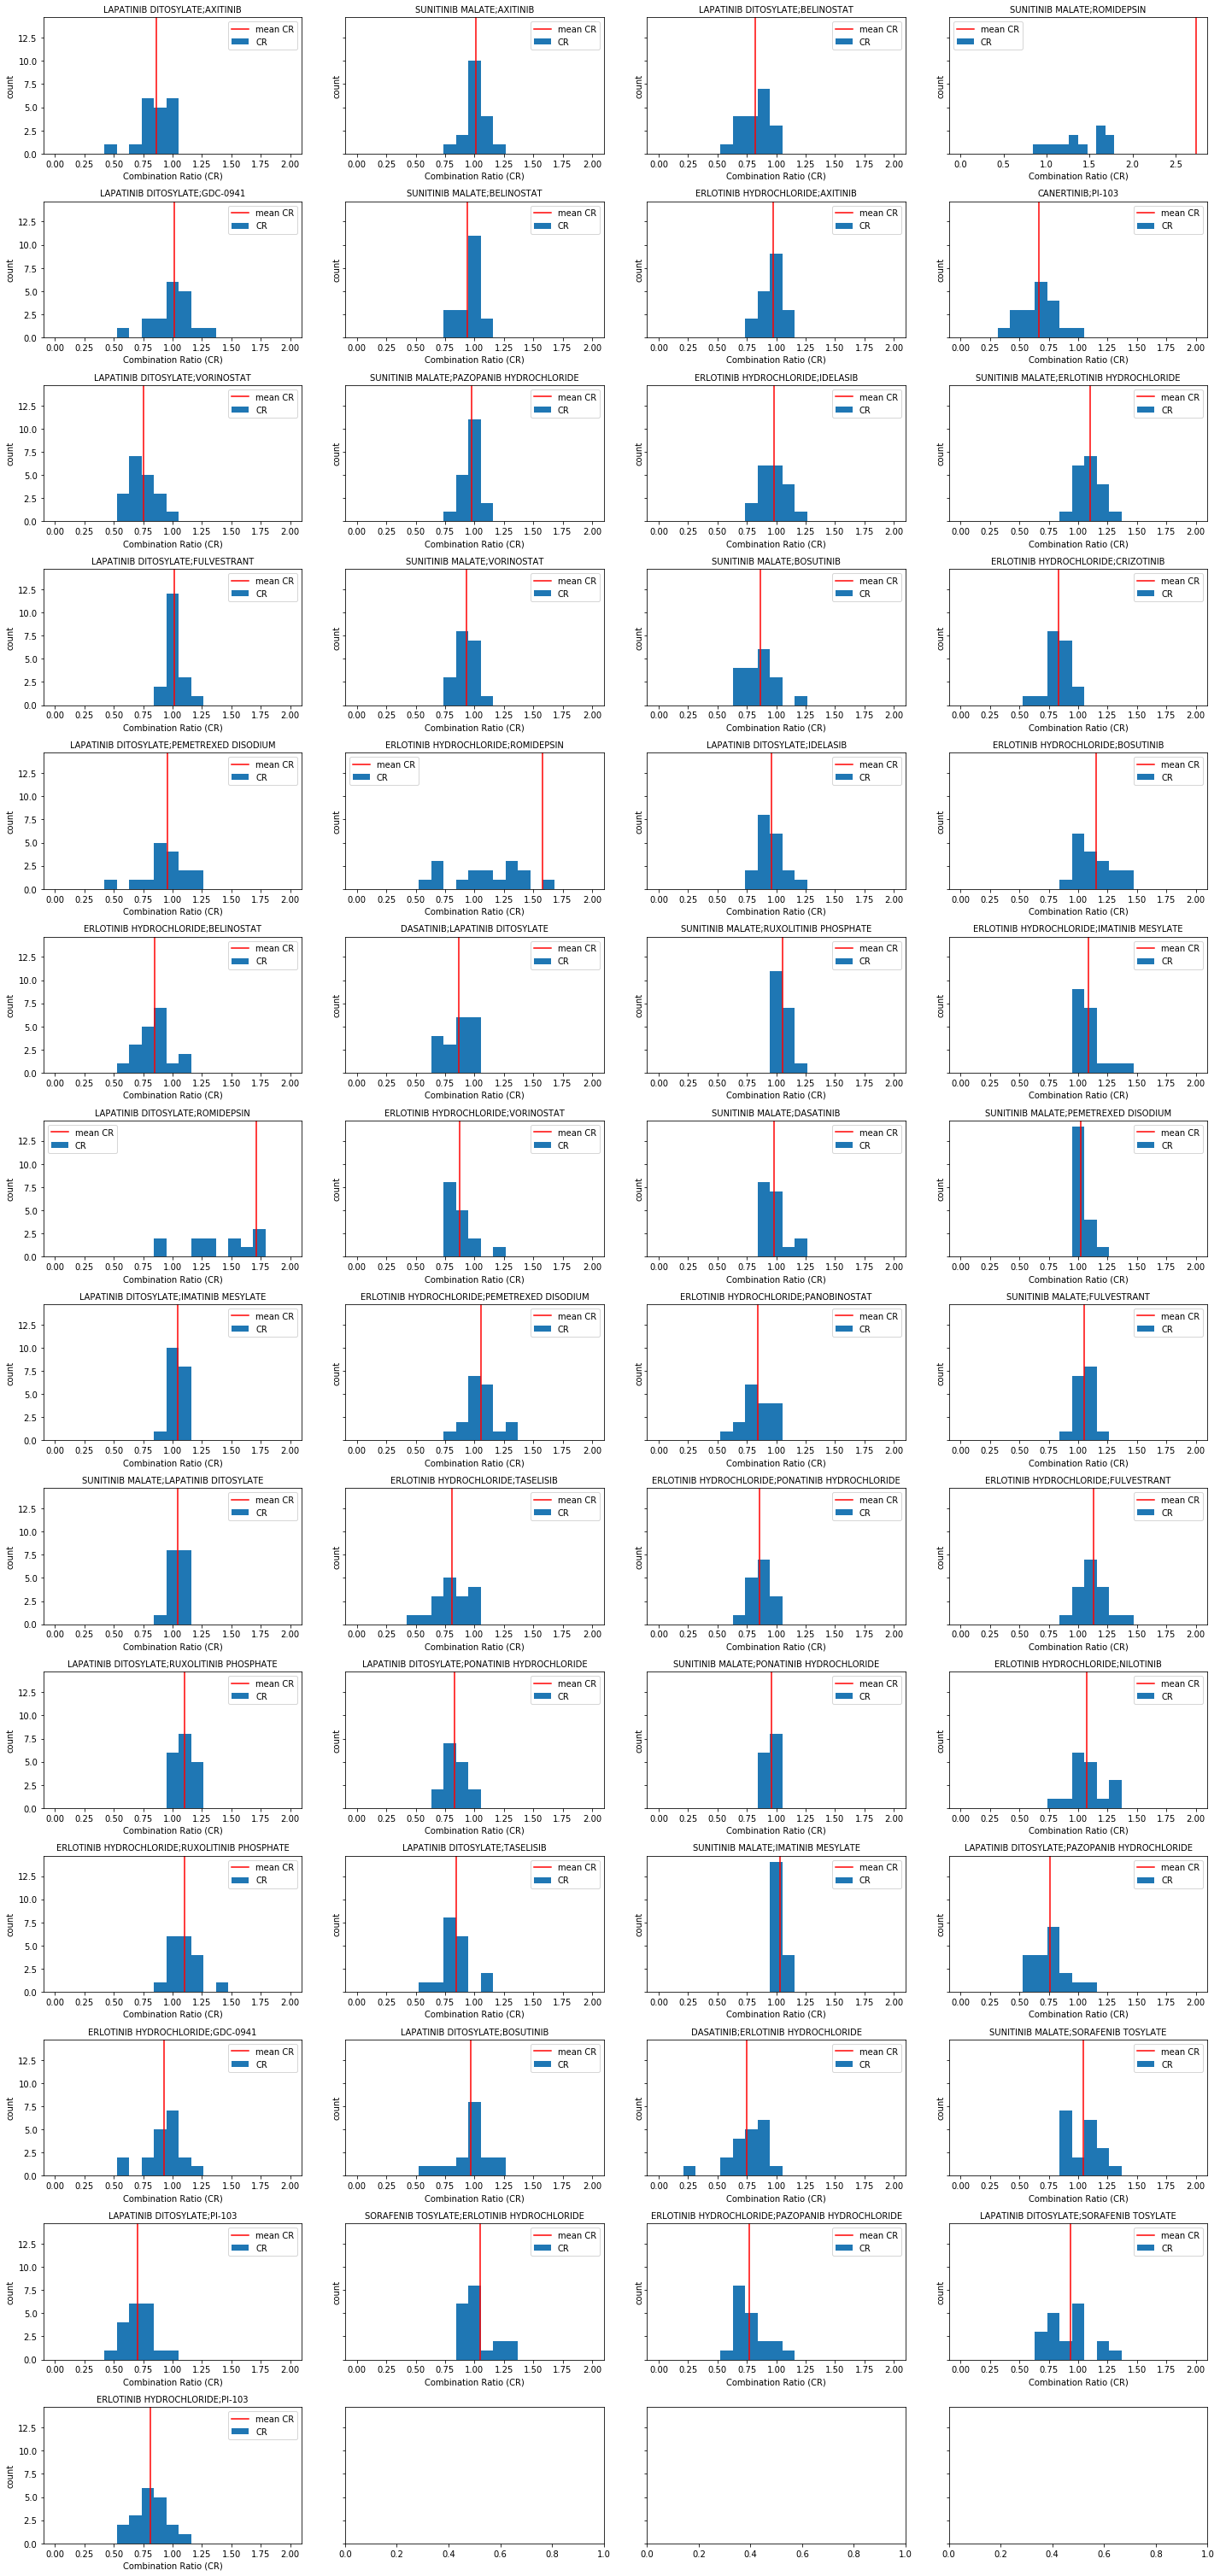

In [30]:
naxes = int(res.inhibitor.unique().shape[0]/4) + 1
f,axes = plt.subplots(naxes,4, figsize=(20,3*naxes), sharex=False, sharey=True)

for ax, comb in zip(axes.flat, res.inhibitor.unique()): 
    df = res[res.inhibitor == comb] 
    ax.hist(df.CR, bins=np.linspace(0,2,20))
    ax.axvline(df.CR.mean(), c='r', label='mean CR')
    ax.set_title(comb, fontsize=10)
    ax.legend()
    ax.set_xlabel('Combination Ratio (CR)')
    ax.set_ylabel('count')
    
plt.tight_layout()
plt.show()    

# Combinations that failed

I suspect most of these failed because the names aren't correct. For instance, if the single agent name is different from it's combination name, it'll fail. 

There are a number of drugs that I misinterpreted as multiple drugs, for those, it should be an easy fix. 

In [31]:
fail = set( failed_combinations )
with open('../output/failed_combinations.txt', 'w') as f: 
    f.write('\n'.join(list(fail)))
    
fail

{'AFATINIB DIMALEATE;GEFITINIB',
 'AXITINIB;GEFITINIB',
 'BOSUTINIB;GEFITINIB',
 'CERITINIB;GEFITINIB',
 'CRIZOTINIB;GEFITINIB',
 'DASATINIB;GEFITINIB',
 'ERLOTINIB HYDROCHLORIDE;AFATINIB DIMALEATE',
 'ERLOTINIB HYDROCHLORIDE;BEZ235',
 'ERLOTINIB HYDROCHLORIDE;BOSUTINIB',
 'ERLOTINIB HYDROCHLORIDE;FULVESTRANT',
 'ERLOTINIB HYDROCHLORIDE;PONATINIB HYDROCHLORIDE',
 'ERLOTINIB HYDROCHLORIDE;TASELISIB',
 'GEFITINIB;BELINOSTAT',
 'GEFITINIB;ERLOTINIB HYDROCHLORIDE',
 'GEFITINIB;FULVESTRANT',
 'GEFITINIB;GDC-0941',
 'GEFITINIB;IDELASIB',
 'GEFITINIB;IMATINIB MESYLATE',
 'GEFITINIB;IMR 1',
 'GEFITINIB;LAPATINIB DITOSYLATE',
 'GEFITINIB;LY3039478',
 'GEFITINIB;NILOTINIB',
 'GEFITINIB;PANOBINOSTAT',
 'GEFITINIB;PAZOPANIB HYDROCHLORIDE',
 'GEFITINIB;PEMETREXED DISODIUM',
 'GEFITINIB;PI-103',
 'GEFITINIB;PONATINIB HYDROCHLORIDE',
 'GEFITINIB;ROMIDEPSIN',
 'GEFITINIB;SORAFENIB TOSYLATE',
 'GEFITINIB;TASELISIB',
 'GEFITINIB;VANDETANIB',
 'GEFITINIB;VORINOSTAT',
 'I-BET 762;BEZ235',
 'I-BET 762;GEFI

# save data

In [32]:
res.to_csv('../output/HNSCC_combination_ratios.csv', index=False)